In [1]:
import pandas as pd
import numpy as np


In [66]:
def preprocess_features(runs_df):
    # convert some int columns to labels
    runs = runs_df.assign(leg_id=runs_df.leg_nro.astype(str))
    runs = runs.assign(num_runs=runs.num_runs.astype(str))
    runs = runs.drop(["leg_nro", "year", "team"], axis=1)
    
    # A columns that contains most poular first names or NA
    runs["first_name"] = runs.name.str.split(" ", expand=True).iloc[:,0]
    runs["first_name"].describe()
    counts = runs["first_name"].value_counts()
    top_counts = counts[counts > 20]

    runs["tfn"] = runs["first_name"]

    def top_name(first_name): 
        if first_name in top_counts:
            return first_name
        else:
            return  "NA"

    runs["tfn"] = runs.apply(lambda run: top_name(run["first_name"]), axis=1)
    display(top_counts.describe())
    
    # Explode categories to dummy columns
    features = pd.get_dummies(runs[["tfn", "leg_id", "num_runs"]], sparse=True)
    # allow linear regression to fit non-linear terms
    features["team_id_log2"] = np.log2(runs.team_id)
    features["team_id_log10"] = np.log10(runs.team_id)
    features["team_id_log100"] = np.log(runs.team_id) / np.log(100)
    features["team_id_square"] = np.square(runs.team_id)
    
    features.insert(0, "team_id", runs["team_id"])

    import json
    with open(f"data/preprocess_priors_feature_columns.json", 'w') as outfile:
        json.dump(features.columns.tolist(), outfile)

    #x = features.values
    x = features[["team_id", "team_id_log10", "team_id_log100", "team_id_log2", "team_id_square", "leg_id_1", "leg_id_2", "leg_id_3", "leg_id_4", "leg_id_5", "leg_id_6", "leg_id_7"]].values # Poista tää.
    y = np.log(runs.pace.values)
    y = y.reshape(len(y), 1)
    
    display(x.shape)
    display(y.shape)

    return (features, x, y)

In [67]:
in_file_name = 'data/runs_ju.tsv'
runs_df = pd.read_csv(in_file_name, delimiter="\t")

(features, x, y) = preprocess_features(runs_df)


count     452.000000
mean      143.420354
std       236.130062
min        21.000000
25%        31.000000
50%        54.000000
75%       131.000000
max      1787.000000
Name: first_name, dtype: float64

(76545, 12)

(76545, 1)

In [68]:
features.head(10)

,team_id,tfn_,tfn_NA,tfn_aapo,tfn_aarne,tfn_aarno,tfn_aaro,tfn_aatu,tfn_adam,tfn_ahti,...,num_runs_3,num_runs_4,num_runs_5,num_runs_6,num_runs_7,num_runs_8,team_id_log2,team_id_log10,team_id_log100,team_id_square
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1.000000,0.301030,0.150515,4
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,4.000000,1.204120,0.602060,256
2,143,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,7.159871,2.155336,1.077668,20449
3,12,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,3.584963,1.079181,0.539591,144
4,37,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,5.209453,1.568202,0.784101,1369
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1.000000,0.301030,0.150515,4
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.000000,0.000000,0.000000,1
7,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3.169925,0.954243,0.477121,81
8,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3.584963,1.079181,0.539591,144
9,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,4.392317,1.322219,0.661110,441


In [69]:
features.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 76545 entries, 0 to 76544
Columns: 475 entries, team_id to team_id_square
dtypes: Sparse[float64, nan](3), Sparse[int64, nan](2), Sparse[uint8, 0](470)
memory usage: 4.0 MB


In [70]:
import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=2019)
x_train.shape

(7654, 12)

In [78]:
import matplotlib.pyplot as plt
def fit_and_test_model(model, x_train, x_test, y_train, y_test, fit_params={}):
    model.fit(x_train, y_train.ravel(), **fit_params)
    y_pred = np.exp(model.predict(x_test))
    print("Mean squared error: %.3f" % mean_squared_error(np.exp(y_test), y_pred))
    print('Explained variance score: %.3f' % r2_score(np.exp(y_test), y_pred))
    
    plt.scatter(x_test[:,0], np.exp(y_test),  color='red', alpha=0.01)
    plt.scatter(x_test[:,0], y_pred, color='blue', alpha=0.01)
    plt.ylim(4, 20)
    plt.show()

Mean squared error: 5.611
Explained variance score: 0.364


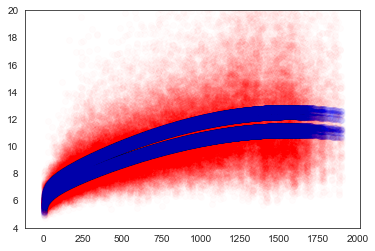

CPU times: user 2.57 s, sys: 241 ms, total: 2.81 s
Wall time: 1.64 s


In [79]:
%%time
linear = linear_model.LinearRegression()
fit_and_test_model(linear, x_train, x_test, y_train, y_test)

      Iter       Train Loss   Remaining Time 
         1           0.0642           22.21s
         2           0.0597           22.04s
         3           0.0560           21.72s
         4           0.0530           21.92s
         5           0.0505           21.97s
         6           0.0484           22.63s
         7           0.0466           23.15s
         8           0.0452           23.16s
         9           0.0440           23.86s
        10           0.0430           23.98s
        20           0.0386           22.76s
        30           0.0374           21.10s
        40           0.0369           19.37s
        50           0.0366           18.14s
        60           0.0363           17.01s
        70           0.0361           16.32s
        80           0.0359           15.75s
        90           0.0357           15.26s
       100           0.0355           14.74s
       200           0.0339           12.42s
       300           0.0328           11.87s
       40

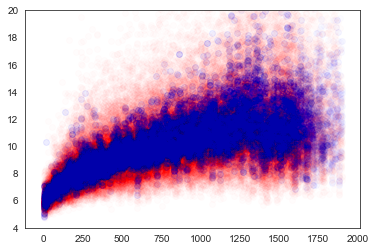

CPU times: user 16 s, sys: 121 ms, total: 16.1 s
Wall time: 15.5 s


In [80]:
%%time

gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=5100, random_state=0, verbose=1)

fit_and_test_model(gbr, x_train, x_test, y_train, y_test)

#print(f"feature_importances_: {gbr.feature_importances_}")
#gbr_features = pd.DataFrame({'feature':first_names.columns, 'importance': gbr.feature_importances_})
#gbr_features['feature'] = gbr_features['feature'].str.replace('top_first_name_','')
#display(gbr_features.sort_values(by="importance", ascending=False))

In [81]:
from pymc3 import  *
import theano
from statsmodels.formula.api import glm as glm_sm
#import statsmodels.api as sm
from pandas.plotting import scatter_matrix

In [82]:
y_and_features = features.copy().assign(pace = y.ravel()).sample(n=1000, random_state=2019)
#y_and_features["pace"] = y.tolist()
y_and_features.head()

,team_id,tfn_,tfn_NA,tfn_aapo,tfn_aarne,tfn_aarno,tfn_aaro,tfn_aatu,tfn_adam,tfn_ahti,...,num_runs_4,num_runs_5,num_runs_6,num_runs_7,num_runs_8,team_id_log2,team_id_log10,team_id_log100,team_id_square,pace
50353,205,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,7.679480,2.311754,1.155877,42025,2.072417
18946,705,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,9.461479,2.848189,1.424095,497025,2.296969
30560,812,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,9.665336,2.909556,1.454778,659344,2.488567
53974,680,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,9.409391,2.832509,1.416254,462400,2.332241
50826,224,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,7.807355,2.350248,1.175124,50176,1.971439


In [86]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=2, sd=5)
    grp_sd = Uniform('grp_sd', 0, 40)
    # Define priors for intercept and regression coefficients.
    priors = {
        'Intercept': Normal.dist(mu=y_and_features.pace.mean(), sd=y_and_features.pace.std()),
        'team_id_log2': Normal.dist(mu=grp_mean, sd=grp_sd),
        'team_id_log10': Normal.dist(mu=grp_mean, sd=grp_sd),
        #'team_id': Normal.dist(mu=grp_mean, sd=grp_sd),
        'team_id_log100': Normal.dist(mu=grp_mean, sd=grp_sd)
    }
    GLM.from_formula('pace ~ team_id_log2 + team_id_log10 + team_id_log100', y_and_features, priors=priors)
    trace_sat = sample(2000, cores=14)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [sd, team_id_log100, team_id_log10, team_id_log2, Intercept, grp_sd, grp_mean]
Sampling 14 chains: 100%|██████████| 35000/35000 [13:19<00:00,  5.52draws/s]  
The acceptance probability does not match the target. It is 0.7073246968939675, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7003203772479715, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accep

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14aefd0b8>,
      dtype=object)

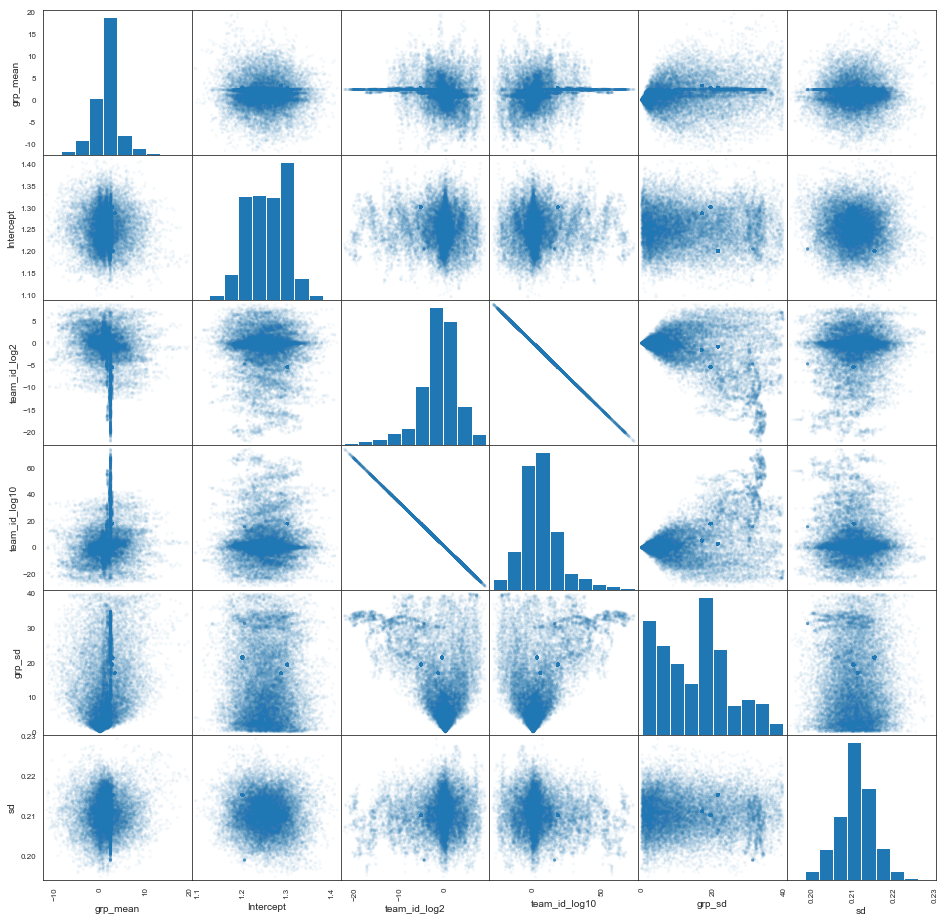

In [62]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(16,16),  alpha=0.05, grid=True)

In [63]:
trace_to_dataframe(trace_sat).describe()

,grp_mean,Intercept,team_id_log2,team_id_log10,grp_sd,sd
count,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000
mean,1.746920,1.255351,-1.645575,5.841586,15.018802,0.210826
std,3.019904,0.044489,4.590328,15.246907,9.813789,0.004449
min,-11.700220,1.095077,-22.247068,-29.429395,0.031287,0.194875
25%,0.246562,1.219353,-3.468432,-1.536854,6.125272,0.208157
50%,2.357868,1.258113,-0.704614,2.734489,16.217793,0.210992
75%,2.898326,1.287723,0.574551,11.901757,21.464904,0.214060
max,19.576318,1.413119,8.975925,74.294894,39.971688,0.229313


In [14]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'
#os.environ['MKL_NUM_THREADS'] = '12'
#os.environ['OMP_NUM_THREADS'] = '12'

import pymc3 as pm
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))


Running on pymc-learn v0.0.1.rc3


In [15]:
pmlearn_linear = LinearRegression()
# fit_params={"inference_args": {"njobs": 12}}
fit_and_test_model(pmlearn_linear, pd.DataFrame(data=x_train), pd.DataFrame(x_test), y_train, y_test)

Average Loss = 71,490: 100%|██████████| 200000/200000 [02:33<00:00, 1299.48it/s]   
Finished [100%]: Average Loss = 71,491
100%|██████████| 2000/2000 [00:29<00:00, 66.85it/s]


Mean squared error: 716245960299468093034282986991854373059170677414051070571312485077775172652616200819863138737722129206510894310875924166251678229594112.000
Explained variance score: -81216021847450586546458359011103215392292638790367074411878385812469249656122726357964292329219846969516595052350329604504211198836736.000


TypeError: '(slice(None, None, None), 0)' is an invalid key

In [16]:
pmlearn_preds = pmlearn_linear.predict(pd.DataFrame(x_test), return_std=True)

100%|██████████| 2000/2000 [00:29<00:00, 74.51it/s]


In [17]:

pd.DataFrame({
    'mean':np.exp(pmlearn_preds[0]), 
    'std':np.exp(pmlearn_preds[1]), 
    'true':np.exp(y_test).ravel()
})

,mean,std,true
0,4.539120e+00,2.300698e+55,7.944
1,5.011635e+10,4.034717e+55,9.944
2,1.276337e+12,3.753669e+55,12.044
3,2.721103e+12,1.318292e+57,10.301
4,2.254311e+01,8.208179e+56,7.181
5,4.611955e+07,5.536124e+56,8.863
6,2.983817e+01,6.668575e+56,8.437
7,3.673867e+08,4.396265e+55,8.730
8,5.635500e+03,1.791743e+57,10.509
9,1.893865e+17,1.335287e+56,12.098


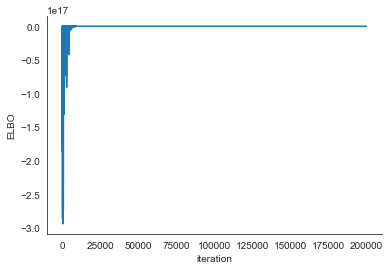

In [18]:
pmlearn_linear.plot_elbo()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1425ff080>,
      dtype=object)

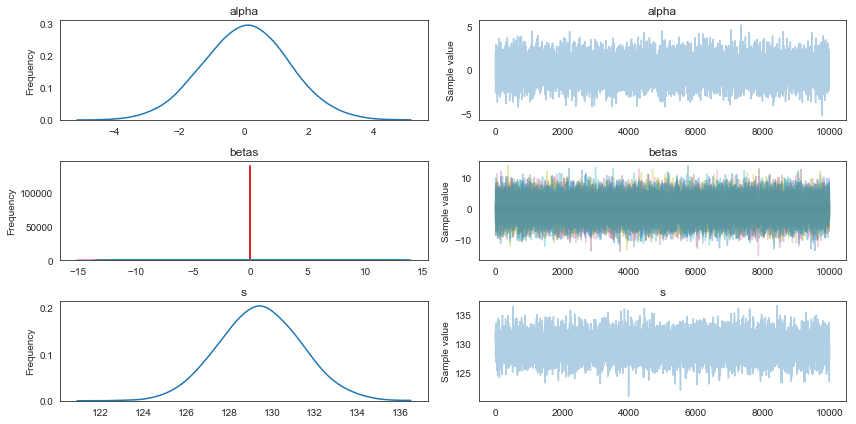

In [19]:
pm.traceplot(pmlearn_linear.trace)

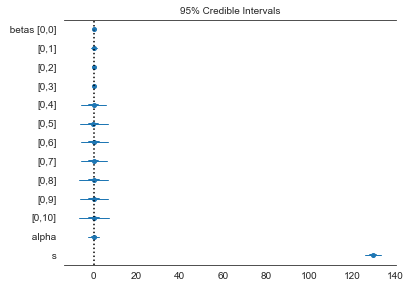

In [20]:
pm.forestplot(pmlearn_linear.trace, varnames=["betas", "alpha", "s"]);

In [21]:
pm.summary(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
betas__0_0,0.003743,0.003171,3.116377e-05,-0.002277,0.010260
betas__0_1,0.042571,0.689583,7.684363e-03,-1.344876,1.390316
betas__0_2,0.054401,0.291048,2.859295e-03,-0.510934,0.621287
betas__0_3,0.000040,0.000003,2.727596e-08,0.000035,0.000046
betas__0_4,0.051438,3.052437,2.991767e-02,-5.926580,5.965717
betas__0_5,0.012440,3.321939,3.286501e-02,-6.154738,6.673960
betas__0_6,0.128000,3.218076,3.238272e-02,-5.964763,6.554347
betas__0_7,0.062573,3.138151,3.180804e-02,-5.981544,6.190456
betas__0_8,0.097000,3.402005,3.240644e-02,-6.692772,6.644014
betas__0_9,0.110142,3.337498,3.869351e-02,-6.330677,6.771948


array([<matplotlib.axes._subplots.AxesSubplot object at 0x13f438a90>,
      dtype=object)

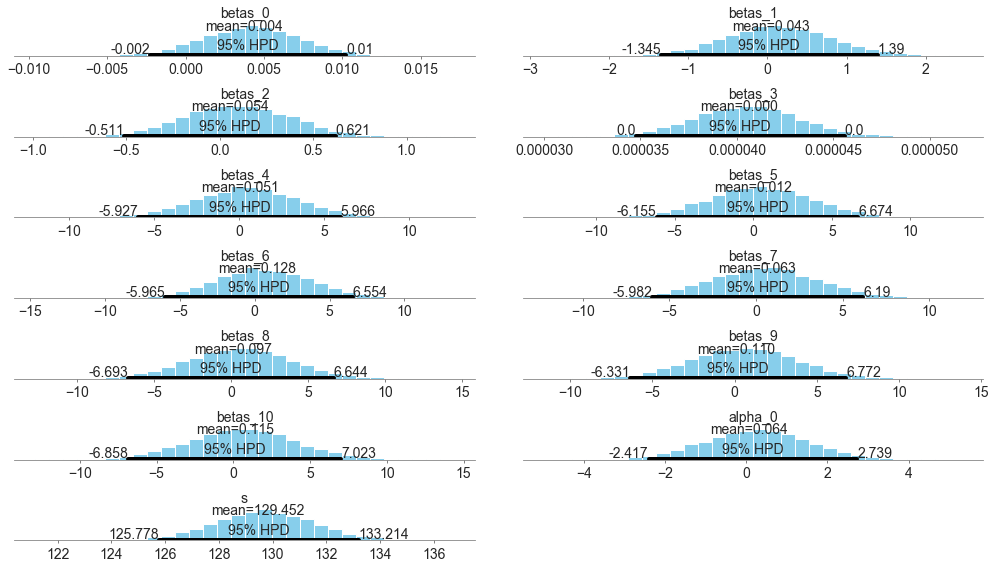

In [22]:
pm.plot_posterior(pmlearn_linear.trace, varnames=["betas", "alpha", "s"],
                 figsize = [14, 8])

In [20]:
pm.gelman_rubin(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])

ValueError: Gelman-Rubin diagnostic requires multiple chains of the same length.